In [84]:
import pandas as pd
import numpy as np

import seaborn as sns
import math

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.metrics as metrics

from imblearn.over_sampling import SMOTE 

pd.set_option('precision', 4)

In [85]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

### Load Data

In [3]:
df_1 = pd.read_csv(r'/Users/kaihayden/Desktop/MSCA/Consulting/fraud/fraudTrain.csv')
df_1.drop_duplicates(inplace=True)
df_1.drop(['Unnamed: 0'], axis=1, inplace=True)

df_2 = pd.read_csv(r'/Users/kaihayden/Desktop/MSCA/Consulting/fraud/fraudTest.csv')
df_2.drop_duplicates(inplace=True)
df_2.drop(['Unnamed: 0'], axis=1, inplace=True)

df = pd.concat([df_1,df_2])
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.0113,-82.0483,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.1590,-118.1865,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.1507,-112.1545,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.0343,-112.5611,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.6750,-78.6325,0


### inspect data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int6

In [5]:
df.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
df.nunique()

trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

In [7]:
df.shape

(1852394, 22)

### fraud frequency

In [8]:
df_fraud=df[['is_fraud','cc_num']].groupby('is_fraud').count().reset_index()
df_fraud.columns=['is_fraud','count']
df_fraud['percentage']=(df_fraud['count']/df_fraud['count'].sum())*100
df_fraud

,is_fraud,count,percentage
0,0,1842743,99.479
1,1,9651,0.521


### convert date and time features

In [9]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

df['trans_year_month'] = df['trans_date_trans_time'].dt.to_period('M')
df['trans_month'] = df['trans_date_trans_time'].dt.month
df['trans_hour']  = df['trans_date_trans_time'].dt.hour
df['trans_dotw']  = df['trans_date_trans_time'].dt.day_name()

df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')
df['age'] = np.round((df['trans_date_trans_time'] - df['dob'])/np.timedelta64(1,'Y'))

# exploratory data analysis

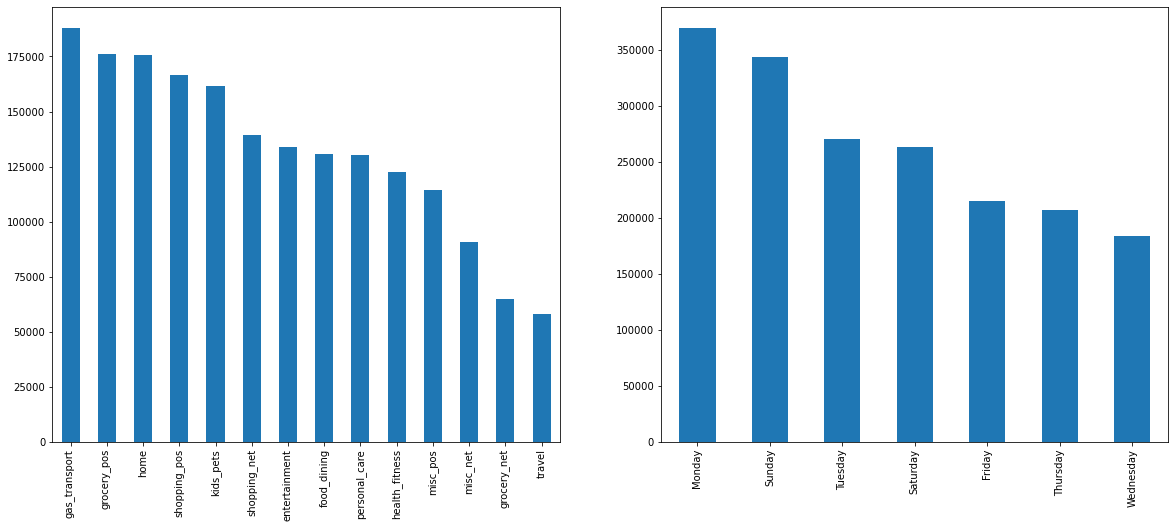

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
df['category'].value_counts().plot.bar();
plt.subplot(1,2,2)
df['trans_dotw'].value_counts().plot.bar();


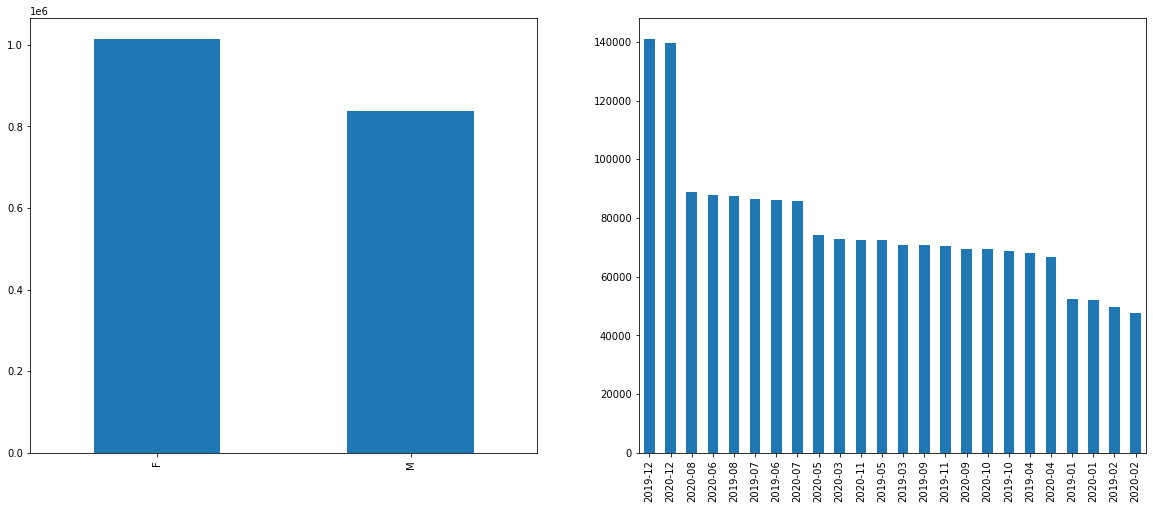

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
df['gender'].value_counts().plot.bar();
plt.subplot(1,2,2)
df['trans_year_month'].value_counts().plot.bar();

In [12]:
pd.concat(
[df['amt'].describe(percentiles = [0.5,0.95,0.999])\
.reset_index().rename(columns={'index': 'Row Type', 'amt':'Overall Amt Distribution'}),
df.loc[df['is_fraud']==0,['amt']].describe(percentiles = [0.5,0.95,0.999])\
.reset_index(drop = 1).rename(columns={'amt':'Non Fraud Amt Distribution'}),
df.loc[df['is_fraud']==1,['amt']].describe(percentiles = [0.5,0.95,0.999])\
.reset_index(drop = 1).rename(columns={'amt':'Fraud Amt Distribution'})],
axis=1
)

,Row Type,Overall Amt Distribution,Non Fraud Amt Distribution,Fraud Amt Distribution
0,count,1.8524e+06,1.8427e+06,9651.0000
1,mean,7.0064e+01,6.7651e+01,530.6614
2,std,1.5925e+02,1.5355e+02,391.0289
3,min,1.0000e+00,1.0000e+00,1.0600
4,50%,4.7450e+01,4.7240e+01,390.0000
5,95%,1.9534e+02,1.8959e+02,1084.0900
6,99.9%,1.5172e+03,1.5196e+03,1293.1270
7,max,2.8949e+04,2.8949e+04,1376.0400


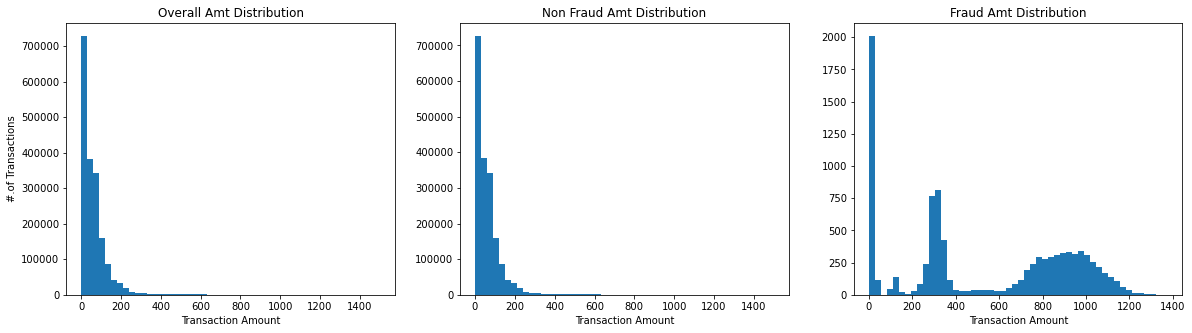

In [13]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(df[df['amt']<=1500]['amt'], bins=50)
ax[1].hist(df[(df['is_fraud']==0) & (df['amt']<=1500)]['amt'], bins=50)
ax[2].hist(df[(df['is_fraud']==1) & (df['amt']<=1500)]['amt'], bins=50)

ax[0].set_title('Overall Amt Distribution')
ax[1].set_title('Non Fraud Amt Distribution')
ax[2].set_title('Fraud Amt Distribution')

ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('#.of Transactions')

ax[1].set_xlabel('Transaction Amount')
ax[2].set_xlabel('Transaction Amount')
plt.show()

### fraud transactions vs fraud customers

In [14]:
df_fraud_transactions = df[df['is_fraud']==1]

df_timeline02 = df_fraud_transactions.groupby(df_fraud_transactions['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline02.columns = ['trans_year_month','num_of_fraud_transactions','fraud_customers']
df_timeline02

,trans_year_month,num_of_fraud_transactions,fraud_customers
0,2019-01,506,50
1,2019-02,517,53
2,2019-03,494,49
3,2019-04,376,41
4,2019-05,408,42
5,2019-06,354,35
6,2019-07,331,36
7,2019-08,382,39
8,2019-09,418,44
9,2019-10,454,50


In [15]:
print(df_timeline02['num_of_fraud_transactions'].mean()/df_timeline02['fraud_customers'].mean())

9.593439363817097


### gender

In [16]:
df_gender = df[['gender','trans_num']].groupby(['gender']).count().reset_index()
df_gender.columns = ['Gender','gender_count']

df_gender['percent'] = (df_gender['gender_count']/df_gender['gender_count'].sum())*100

df_gender

,Gender,gender_count,percent
0,F,1014749,54.7804
1,M,837645,45.2196


In [17]:
df_fraud_gender = df[['gender','is_fraud','trans_num']].groupby(['gender','is_fraud']).count().reset_index()
df_fraud_gender.columns = ['Gender','is_fraud','count']

df_fraud_gender = df_fraud_gender.merge(df_gender[['Gender','gender_count']],how='inner',\
                                  left_on='Gender',right_on='Gender')


df_fraud_gender['percent_grp'] = (df_fraud_gender['count']/df_fraud_gender['gender_count'])*100


df_fraud_gender

,Gender,is_fraud,count,gender_count,percent_grp
0,F,0,1009850,1014749,99.5172
1,F,1,4899,1014749,0.4828
2,M,0,832893,837645,99.4327
3,M,1,4752,837645,0.5673


### category

In [18]:
df_category = df[['category','trans_num']].groupby(['category']).count().reset_index()
df_category.columns = ['Category','category_count']

df_category['percent'] = (df_category['category_count']/df_category['category_count'].sum())*100

df_category.sort_values(by = ['percent'], ascending=False)

,Category,category_count,percent
2,gas_transport,188029,10.1506
4,grocery_pos,176191,9.5115
6,home,175460,9.4721
12,shopping_pos,166463,8.9864
7,kids_pets,161727,8.7307
11,shopping_net,139322,7.5212
0,entertainment,134118,7.2403
1,food_dining,130729,7.0573
10,personal_care,130085,7.0225
5,health_fitness,122553,6.6159


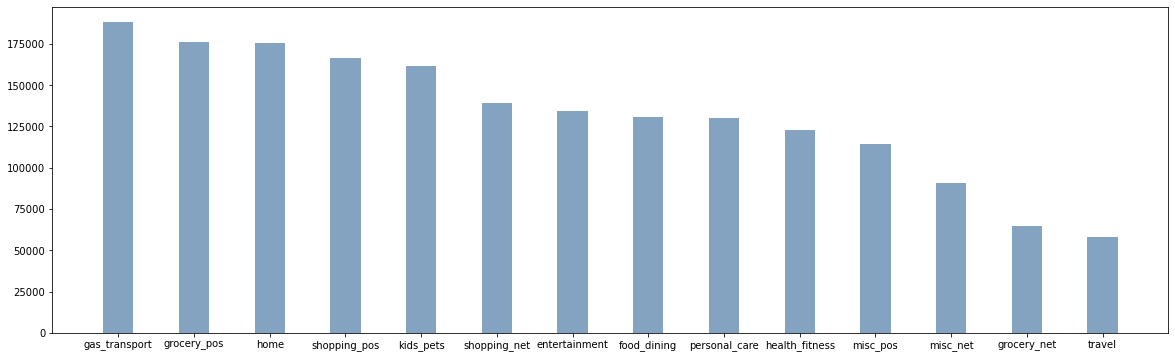

In [19]:
df_category = df_category.sort_values(by = ['percent'], ascending=False).reset_index()
fig = plt.figure(figsize = (20, 6)) 


plt.bar(df_category['Category'], df_category['category_count'], color=(0.2, 0.4, 0.6, 0.6),  
        width = 0.4)

plt.show()

In [20]:
df_fraud_category = df[['category','is_fraud','trans_num']].groupby(['category','is_fraud']).count().reset_index()
df_fraud_category.columns = ['Category','is_fraud','count']

df_fraud_category = df_fraud_category.merge(df_category[['Category','category_count','percent']],how='inner',\
                                  left_on='Category',right_on='Category')


df_fraud_category['percent_grp'] = (df_fraud_category['count']/df_fraud_category['category_count'])*100


In [21]:
df_fraud=df_fraud_category[df_fraud_category['is_fraud']==1].sort_values(by = ['percent_grp'], ascending=False)
df_fraud

,Category,is_fraud,count,category_count,percent,percent_grp
23,shopping_net,1,2219,139322,7.5212,1.5927
17,misc_net,1,1182,90654,4.8939,1.3039
9,grocery_pos,1,2228,176191,9.5115,1.2645
25,shopping_pos,1,1056,166463,8.9864,0.6344
5,gas_transport,1,772,188029,10.1506,0.4106
19,misc_pos,1,322,114229,6.1666,0.2819
7,grocery_net,1,175,64878,3.5024,0.2697
27,travel,1,156,57956,3.1287,0.2692
21,personal_care,1,290,130085,7.0225,0.2229
1,entertainment,1,292,134118,7.2403,0.2177


### merchant

In [22]:
df.merchant.value_counts(normalize=True, ascending=False)

fraud_Kilback LLC                        0.0034
fraud_Cormier LLC                        0.0028
fraud_Schumm PLC                         0.0028
fraud_Kuhn LLC                           0.0027
fraud_Boyer PLC                          0.0027
                                          ...  
fraud_Douglas, DuBuque and McKenzie      0.0006
fraud_Treutel-King                       0.0006
fraud_Satterfield-Lowe                   0.0006
fraud_Hahn, Douglas and Schowalter       0.0006
fraud_Ritchie, Bradtke and Stiedemann    0.0006
Name: merchant, Length: 693, dtype: float64

In [23]:
df_merchant = df[['merchant','trans_num']].groupby(['merchant']).count().reset_index()
df_merchant.columns = ['Merchant','merchant_count']

df_merchant['percent'] = (df_merchant['merchant_count']/df_merchant['merchant_count'].sum())*100

df_merchant.sort_values(by = ['percent'], ascending=False)

,Merchant,merchant_count,percent
316,fraud_Kilback LLC,6262,0.3380
105,fraud_Cormier LLC,5246,0.2832
571,fraud_Schumm PLC,5195,0.2804
349,fraud_Kuhn LLC,5031,0.2716
70,fraud_Boyer PLC,4999,0.2699
...,...,...,...
143,"fraud_Douglas, DuBuque and McKenzie",1101,0.0594
633,fraud_Treutel-King,1098,0.0593
544,fraud_Satterfield-Lowe,1095,0.0591
221,"fraud_Hahn, Douglas and Schowalter",1091,0.0589


In [24]:
df_fraud_merchant = df[['merchant','is_fraud','trans_num']].groupby(['merchant','is_fraud']).count().reset_index()
df_fraud_merchant.columns = ['Merchant','is_fraud','count']

df_fraud_merchant = df_fraud_merchant.merge(df_merchant[['Merchant','merchant_count','percent']],how='inner',\
                                  left_on='Merchant',right_on='Merchant')


df_fraud_merchant['percent_grp'] = (df_fraud_merchant['count']/df_fraud_merchant['merchant_count'])*100

In [25]:
df_fraud_merchant[df_fraud_merchant['is_fraud'] == 1].sort_values(by = ['percent_grp'],ascending=False)

,Merchant,is_fraud,count,merchant_count,percent,percent_grp
673,fraud_Kozey-Boehm,1,60,2758,0.1489,2.1755
490,"fraud_Herman, Treutel and Dickens",1,38,1870,0.1010,2.0321
1226,fraud_Terry-Huel,1,56,2864,0.1546,1.9553
607,fraud_Kerluke-Abshire,1,50,2635,0.1422,1.8975
884,"fraud_Mosciski, Ziemann and Farrell",1,53,2821,0.1523,1.8788
...,...,...,...,...,...,...
775,"fraud_Lesch, D'Amore and Brown",1,1,2659,0.1435,0.0376
1089,"fraud_Schaefer, Fay and Hilll",1,1,2664,0.1438,0.0375
950,"fraud_Parker, Nolan and Trantow",1,1,2795,0.1509,0.0358
1335,fraud_Windler LLC,1,1,3170,0.1711,0.0315


In [26]:
category_onehot = pd.get_dummies(df.category, prefix='category', drop_first=True)
gender_onehot = pd.get_dummies(df.gender, prefix='gender', drop_first=True)
day_of_week_onehot = pd.get_dummies(df.trans_dotw, prefix='week',drop_first=True)

In [27]:
df1 = pd.concat([df, category_onehot,gender_onehot,day_of_week_onehot], axis=1)

In [28]:
df1['dist'] = haversine(df1['lat'],df1['long'],df1['merch_lat'],df1['merch_long'])

### historic variables

In [29]:
df1.index = pd.to_datetime(df1['trans_date_trans_time'])
df1 = df1.rename_axis(index={'trans_date_trans_time': 'time_index'})
df1 = df1.sort_index()
df1.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,category_shopping_pos,category_travel,gender_M,week_Monday,week_Saturday,week_Sunday,week_Thursday,week_Tuesday,week_Wednesday,dist
time_index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,0,0,0,0,0,0,1,0,78.5976
2019-01-01 00:00:44,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,0,0,0,0,0,0,1,0,30.2122
2019-01-01 00:00:51,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,0,1,0,0,0,0,1,0,108.2061
2019-01-01 00:01:16,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,0,1,0,0,0,0,1,0,95.6732
2019-01-01 00:03:06,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,0,1,0,0,0,0,1,0,77.5567


In [30]:
df1['val_for_agg'] = 1

### 30 day transaction count

In [31]:
df_hist_trans_30d = \
    df1 \
    .groupby(['cc_num'])['val_for_agg']\
    .rolling('30D')\
    .count()\
    .shift()\
    .reset_index()\
    .fillna(0)

df_hist_trans_30d.columns = ['cc_num','trans_date','hist_trans_30d']

In [32]:
df_hist_trans_30d['trans_date'] = df_hist_trans_30d['trans_date'].dt.date

In [33]:
df_hist_trans_30d = df_hist_trans_30d.groupby(['cc_num','trans_date'])['hist_trans_30d'].min().reset_index()

In [34]:
df_hist_trans_30d

,cc_num,trans_date,hist_trans_30d
0,60416207185,2019-01-01,0.0
1,60416207185,2019-01-02,1.0
2,60416207185,2019-01-03,5.0
3,60416207185,2019-01-04,7.0
4,60416207185,2019-01-05,9.0
...,...,...,...
554281,4992346398065154184,2020-12-27,167.0
554282,4992346398065154184,2020-12-28,170.0
554283,4992346398065154184,2020-12-29,177.0
554284,4992346398065154184,2020-12-30,183.0


### 24 hour transaction count

In [35]:
df_hist_orders_24h = \
    df1 \
    .groupby(['cc_num'])['val_for_agg']\
    .rolling('24H')\
    .count()\
    .shift()\
    .reset_index()\
    .fillna(0)

df_hist_orders_24h.columns = ['cc_num','trans_date_trans_time','hist_trans_24h']

In [36]:
df_hist_fraud_trans_24h = \
    df1[df1['is_fraud']== 1]\
    .groupby(['cc_num'])['val_for_agg']\
    .rolling('24H')\
    .count()\
    .shift()\
    .reset_index()\
    .fillna(0)

df_hist_fraud_trans_24h.columns = ['cc_num','trans_date_trans_time','hist_fraud_trans_24h']

### 2 hour fraud count

In [37]:
df_hist_fraud_trans_2h = \
    df1[df1['is_fraud']== 1]\
    .groupby(['cc_num'])['val_for_agg']\
    .rolling('2H')\
    .count()\
    .shift()\
    .reset_index()\
    .fillna(0)

df_hist_fraud_trans_2h.columns = ['cc_num','trans_date_trans_time','hist_fraud_trans_2h']

### 30 day average orders

In [38]:
df_hist_trans_amt_avg_30d = \
    df1 \
    .groupby(['cc_num'])['amt']\
    .rolling('30D')\
    .mean()\
    .shift(1)\
    .reset_index()\
    .fillna(0)

df_hist_trans_amt_avg_30d.columns = ['cc_num','trans_date','hist_trans_avg_amt_30d']

In [39]:
df_hist_trans_amt_avg_30d['trans_date'] = df_hist_trans_amt_avg_30d['trans_date'].dt.date

In [40]:
df_hist_trans_amt_avg_30d = df_hist_trans_amt_avg_30d.groupby(['cc_num','trans_date'])\
['hist_trans_avg_amt_30d'].min().reset_index()

In [41]:
df_hist_trans_amt_avg_30d.head(10)

,cc_num,trans_date,hist_trans_avg_amt_30d
0,60416207185,2019-01-01,0.0000
1,60416207185,2019-01-02,7.2700
2,60416207185,2019-01-03,35.1883
3,60416207185,2019-01-04,31.3657
4,60416207185,2019-01-05,40.3789
5,60416207185,2019-01-06,43.0536
6,60416207185,2019-01-07,48.0050
7,60416207185,2019-01-08,60.0162
8,60416207185,2019-01-09,70.4231
9,60416207185,2019-01-10,69.7539


# customers

In [42]:
df1

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,category_travel,gender_M,week_Monday,week_Saturday,week_Sunday,week_Thursday,week_Tuesday,week_Wednesday,dist,val_for_agg
time_index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,0,0,0,0,0,1,0,78.5976,1
2019-01-01 00:00:44,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,0,0,0,0,0,1,0,30.2122,1
2019-01-01 00:00:51,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,1,0,0,0,0,1,0,108.2061,1
2019-01-01 00:01:16,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,1,0,0,0,0,1,0,95.6732,1
2019-01-01 00:03:06,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,1,0,0,0,0,1,0,77.5567,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:59:07,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,0,1,0,0,0,1,0,0,77.0261,1
2020-12-31 23:59:09,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,0,1,0,0,0,1,0,0,100.0744,1
2020-12-31 23:59:15,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,0,0,0,0,0,1,0,0,80.7593,1


In [43]:
df_customer_avg_merchant_spend = df1[['cc_num','merchant','amt']].reset_index()\
                                                                 .groupby(['cc_num','merchant'])['amt']\
                                                                 .agg(mean_merchant_spend='mean',median_merchant_spend='median').reset_index()
df_customer_avg_merchant_spend

,cc_num,merchant,mean_merchant_spend,median_merchant_spend
0,60416207185,fraud_Abbott-Rogahn,23.2767,27.830
1,60416207185,fraud_Abbott-Steuber,49.5250,43.840
2,60416207185,fraud_Abernathy and Sons,18.3633,15.030
3,60416207185,fraud_Abshire PLC,66.1300,71.705
4,60416207185,"fraud_Adams, Kovacek and Kuhlman",78.2767,79.440
...,...,...,...,...
529323,4992346398065154184,fraud_Zemlak Group,164.4667,216.640
529324,4992346398065154184,"fraud_Zemlak, Tillman and Cremin",35.3780,30.590
529325,4992346398065154184,fraud_Ziemann-Waters,43.3400,30.650
529326,4992346398065154184,"fraud_Zieme, Bode and Dooley",55.7810,56.085


In [44]:
df_customer_avg_spend = df1[['cc_num','amt']].reset_index()\
                                             .groupby(['cc_num'])['amt']\
                                             .agg(mean_spend='mean',median_spend='median').reset_index()
df_customer_avg_spend

,cc_num,mean_spend,median_spend
0,60416207185,59.2578,36.540
1,60422928733,65.4832,51.405
2,60423098130,96.3761,35.425
3,60427851591,107.4876,76.670
4,60487002085,64.0969,35.670
...,...,...,...
994,4958589671582726883,67.2056,50.130
995,4973530368125489546,75.7891,52.660
996,4980323467523543940,70.7095,42.515
997,4989847570577635369,93.0089,57.170


In [45]:
df_customer_merchant_visits = df1[['cc_num','merchant','amt']].reset_index()\
                                                              .groupby(['cc_num','merchant'])['amt']\
                                                              .count().reset_index()
df_customer_merchant_visits.rename(columns={"amt": "customer_merchant_visits"},inplace=True)

df_customer_merchant_visits

,cc_num,merchant,customer_merchant_visits
0,60416207185,fraud_Abbott-Rogahn,3
1,60416207185,fraud_Abbott-Steuber,6
2,60416207185,fraud_Abernathy and Sons,3
3,60416207185,fraud_Abshire PLC,4
4,60416207185,"fraud_Adams, Kovacek and Kuhlman",3
...,...,...,...
529323,4992346398065154184,fraud_Zemlak Group,3
529324,4992346398065154184,"fraud_Zemlak, Tillman and Cremin",5
529325,4992346398065154184,fraud_Ziemann-Waters,5
529326,4992346398065154184,"fraud_Zieme, Bode and Dooley",10


### merges

In [46]:
df1['trans_date'] = df1['trans_date_trans_time'].dt.date

In [47]:
df1 = df1.merge(df_hist_trans_30d,left_on = ['cc_num','trans_date'], \
          right_on = ['cc_num','trans_date'],how = 'left')

In [48]:
df1 = df1.merge(df_hist_orders_24h,left_on = ['cc_num','trans_date_trans_time'], \
          right_on = ['cc_num','trans_date_trans_time'],how = 'left')

df1 = df1.merge(df_hist_fraud_trans_24h,left_on = ['cc_num','trans_date_trans_time'], \
          right_on = ['cc_num','trans_date_trans_time'],how = 'left')

df1 = df1.merge(df_hist_fraud_trans_2h,left_on = ['cc_num','trans_date_trans_time'], \
          right_on = ['cc_num','trans_date_trans_time'],how = 'left')

df1 = df1.merge(df_hist_trans_amt_avg_30d,left_on = ['cc_num','trans_date'], \
          right_on = ['cc_num','trans_date'],how = 'left')

In [49]:
df1 = df1.merge(df_customer_avg_spend, on=['cc_num'], how='left')

df1 = df1.merge(df_customer_avg_merchant_spend, on=['cc_num','merchant'], how='left')

df1 = df1.merge(df_customer_merchant_visits, on=['cc_num','merchant'], how='left')

In [50]:
df1['multiple_of_avg_merchant_amt'] = df1['amt']/df1['mean_merchant_spend']
df1['multiple_of_med_merchant_amt'] = df1['amt']/df1['median_merchant_spend']
df1['multiple_of_avg_amt'] = df1['amt']/df1['mean_spend']
df1['multiple_of_med_amt'] = df1['amt']/df1['median_spend']

df1[['hist_trans_30d','hist_trans_24h','hist_fraud_trans_24h','hist_fraud_trans_2h','hist_trans_avg_amt_30d']]= \
df1[['hist_trans_30d','hist_trans_24h','hist_fraud_trans_24h','hist_fraud_trans_2h','hist_trans_avg_amt_30d']].fillna(0)

In [51]:
df1.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_year_month', 'trans_month',
       'trans_hour', 'trans_dotw', 'age', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'week_Monday',
       'week_Saturday', 'week_Sunday', 'week_Thursday', 'week_Tuesday',
       'week_Wednesday', 'dist', 'val_for_agg', 'trans_date', 'hist_trans_30d',
       'hist_trans_24h', 'hist_fraud_trans_24h', 'hist_fraud_trans_2h',
       'hist_trans_avg_amt_30d', 'mean_spend', 'median_spend',
       'mean

In [52]:
cols_demographic = ['city_pop']

cols_customer = ['age','gender_M']

cols_transaction = ['trans_hour','category_food_dining',
                    'category_gas_transport','category_grocery_net',
                    'category_grocery_pos','category_health_fitness','category_home',
                    'category_kids_pets','category_misc_net','category_misc_pos',
                    'category_personal_care','category_shopping_net',
                    'category_shopping_pos','category_travel','week_Monday',
                    'week_Saturday','week_Sunday','week_Thursday','week_Tuesday',
                    'week_Wednesday', 'amt']

cols_rolling_transaction = ['hist_trans_30d', 'hist_trans_24h',
                            'hist_fraud_trans_24h','hist_fraud_trans_2h',
                            'hist_trans_avg_amt_30d']

cols_customer_transaction = ['multiple_of_avg_amt']
# category percent

cols_customer_merchant = ['dist','customer_merchant_visits']

cols_customer_merchant_transaction = ['multiple_of_avg_merchant_amt', 'multiple_of_med_merchant_amt']

cols = cols_demographic+cols_customer+cols_transaction+cols_rolling_transaction+cols_customer_transaction+cols_customer_merchant+cols_customer_merchant_transaction+['is_fraud']

In [53]:
cols

['city_pop',
 'age',
 'gender_M',
 'trans_hour',
 'category_food_dining',
 'category_gas_transport',
 'category_grocery_net',
 'category_grocery_pos',
 'category_health_fitness',
 'category_home',
 'category_kids_pets',
 'category_misc_net',
 'category_misc_pos',
 'category_personal_care',
 'category_shopping_net',
 'category_shopping_pos',
 'category_travel',
 'week_Monday',
 'week_Saturday',
 'week_Sunday',
 'week_Thursday',
 'week_Tuesday',
 'week_Wednesday',
 'amt',
 'hist_trans_30d',
 'hist_trans_24h',
 'hist_fraud_trans_24h',
 'hist_fraud_trans_2h',
 'hist_trans_avg_amt_30d',
 'multiple_of_avg_amt',
 'dist',
 'customer_merchant_visits',
 'multiple_of_avg_merchant_amt',
 'multiple_of_med_merchant_amt',
 'is_fraud']

In [54]:
corr = df1[cols].corr()

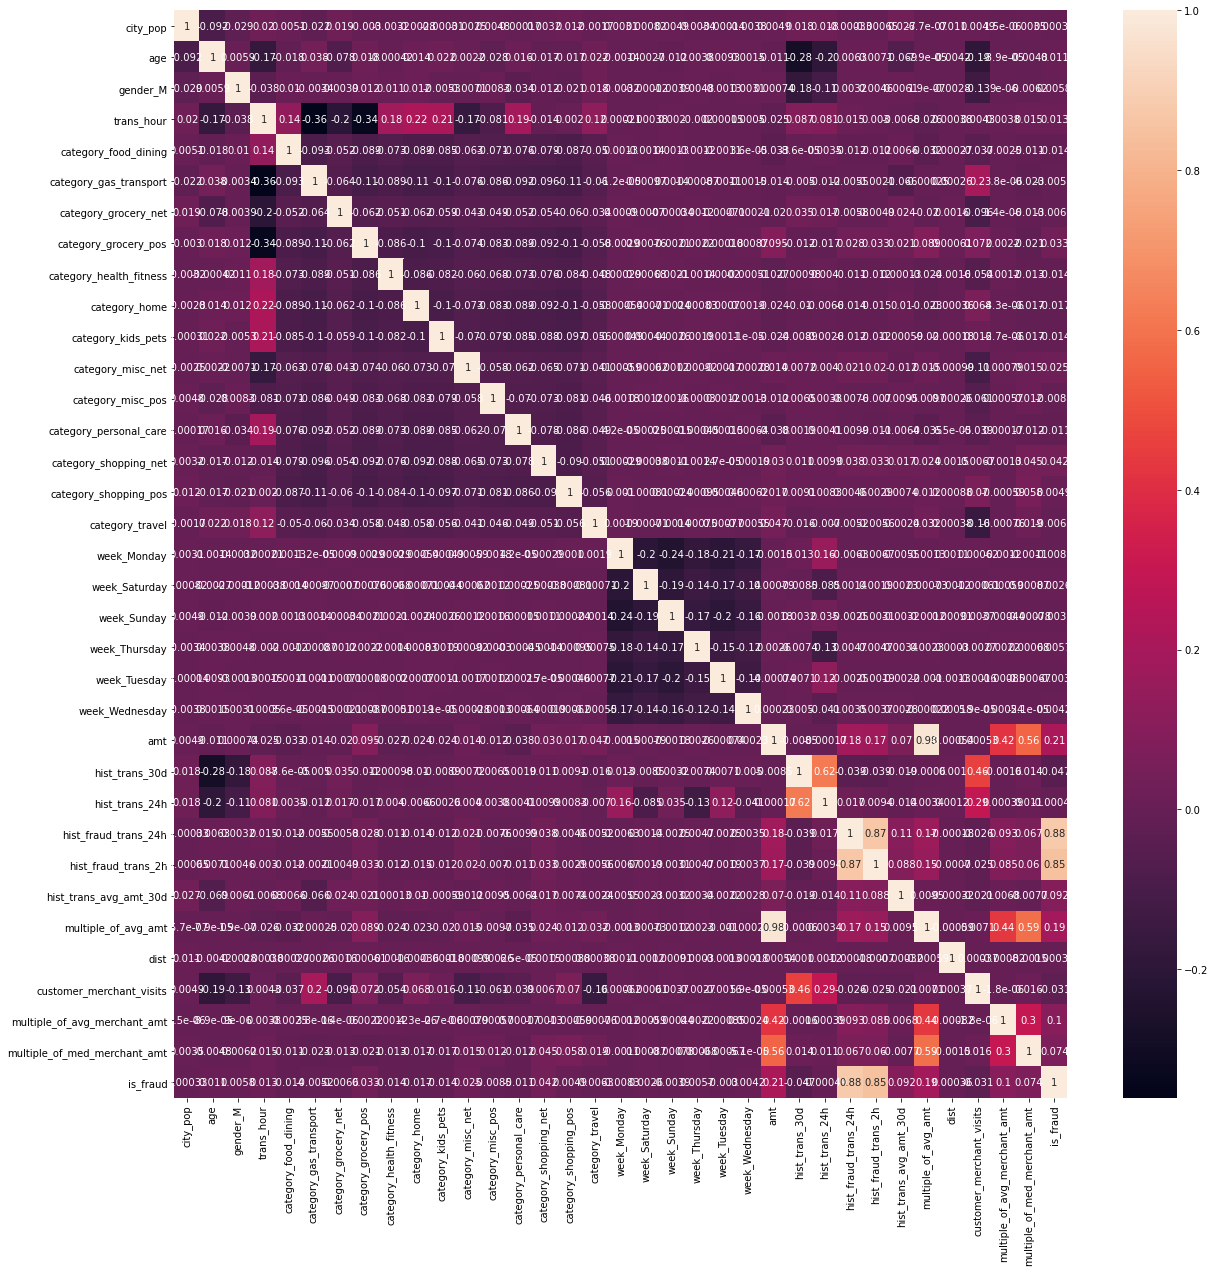

In [55]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, annot=True)
plt.show()

In [56]:
corr.loc['is_fraud'].sort_values(ascending=False)

is_fraud                        1.0000
hist_fraud_trans_24h            0.8828
hist_fraud_trans_2h             0.8482
amt                             0.2093
multiple_of_avg_amt             0.1874
multiple_of_avg_merchant_amt    0.1031
hist_trans_avg_amt_30d          0.0922
multiple_of_med_merchant_amt    0.0736
category_shopping_net           0.0425
category_grocery_pos            0.0335
category_misc_net               0.0247
trans_hour                      0.0132
age                             0.0107
gender_M                        0.0058
week_Thursday                   0.0057
category_shopping_pos           0.0049
week_Wednesday                  0.0042
week_Saturday                   0.0026
dist                            0.0004
city_pop                        0.0003
hist_trans_24h                 -0.0005
week_Tuesday                   -0.0030
week_Sunday                    -0.0039
category_gas_transport         -0.0052
category_travel                -0.0063
category_grocery_net     

In [57]:
xcols = ['city_pop','trans_hour','age','category_food_dining',
       'category_gas_transport','category_grocery_net',
       'category_grocery_pos','category_health_fitness','category_home',
       'category_kids_pets','category_misc_net','category_misc_pos',
       'category_personal_care','category_shopping_net',
       'category_shopping_pos','category_travel','gender_M','week_Monday',
       'week_Saturday','week_Sunday','week_Thursday','week_Tuesday',
       'week_Wednesday','dist','hist_trans_30d',
       'hist_trans_24h', 'hist_fraud_trans_24h','hist_fraud_trans_2h',
       'hist_trans_avg_amt_30d', 'amt', 'multiple_of_avg_amt', 'multiple_of_med_amt',
       'customer_merchant_visits']

In [58]:
ycols = ['is_fraud']

In [59]:
df_x = df1[xcols]
df_y = df1[ycols]

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
sme = SMOTE(random_state=1, sampling_strategy=0.5)

Xtrain, Xtest, ytrain, ytest = train_test_split(df_x, df_y, test_size=0.3, random_state=1,stratify=df_y)
Xtrain_res, ytrain_res = sme.fit_resample(Xtrain, ytrain)

In [62]:
Xtrain_res.shape

(1934971, 33)

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
logreg = LogisticRegression(random_state=1)

In [93]:
logreg.fit(Xtrain_res, ytrain_res)

/Users/kaihayden/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/kaihayden/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1)

In [94]:
ypred = logreg.predict(Xtest)

In [95]:
print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred))

[[534392  18458]
 [   862   2033]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    552850
           1       0.10      0.70      0.17      2895

    accuracy                           0.97    555745
   macro avg       0.55      0.83      0.58    555745
weighted avg       0.99      0.97      0.98    555745



In [96]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypred)
roc_auc = metrics.auc(fpr, tpr)

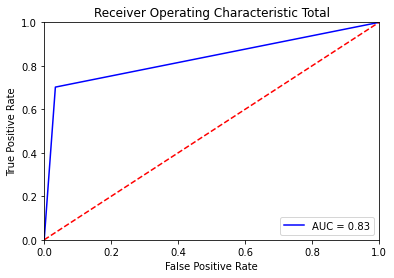

In [97]:
plt.title('Receiver Operating Characteristic Total')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--');plt.xlim([0, 1]);plt.ylim([0, 1])
plt.ylabel('True Positive Rate');plt.xlabel('False Positive Rate')
plt.show()

# Logistic Regression

### Accuracy: 97%
### Precision: 10%
### Recall: 70%

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [99]:
dt_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 30, random_state=1)
dt_clf.fit(Xtrain_res, ytrain_res)

DecisionTreeClassifier(max_depth=30, random_state=1)

In [100]:
ypred = dt_clf.predict(Xtest)

print(confusion_matrix(ypred, ytest))
print(classification_report(ypred, ytest))

[[552849      0]
 [     1   2895]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552849
           1       1.00      1.00      1.00      2896

    accuracy                           1.00    555745
   macro avg       1.00      1.00      1.00    555745
weighted avg       1.00      1.00      1.00    555745



In [101]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypred)
roc_auc = metrics.auc(fpr, tpr)

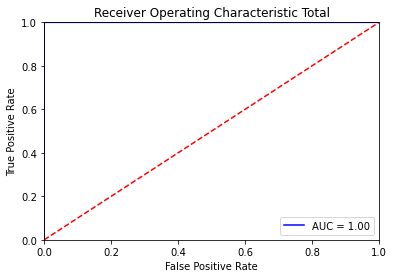

In [102]:
plt.title('Receiver Operating Characteristic Total')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--');plt.xlim([0, 1]);plt.ylim([0, 1])
plt.ylabel('True Positive Rate');plt.xlabel('False Positive Rate')
plt.show()

# Decision Tree Results

### Accuracy: 100%
### Precision: 100%
### Recall: 100%

In [103]:
from sklearn.ensemble import RandomForestClassifier

In [104]:
rf_clf = RandomForestClassifier(n_estimators = 50,max_depth = 20,
                                random_state=1, verbose = 1)
rf_clf.fit(Xtrain_res, ytrain_res)

<ipython-input-104-8c0f631d8a6e>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(Xtrain_res, ytrain_res)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.0min finished


RandomForestClassifier(max_depth=20, n_estimators=50, random_state=1, verbose=1)

In [105]:
print("Test Results")
ypred = rf_clf.predict(Xtest)

print(confusion_matrix(ytest, ypred))
print(classification_report(ytest, ypred, digits=5))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Test Results


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.1s finished


[[552850      0]
 [     0   2895]]
              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000    552850
           1    1.00000   1.00000   1.00000      2895

    accuracy                        1.00000    555745
   macro avg    1.00000   1.00000   1.00000    555745
weighted avg    1.00000   1.00000   1.00000    555745



In [106]:
fpr, tpr, threshold = metrics.roc_curve(ytest, ypred)
roc_auc = metrics.auc(fpr, tpr)

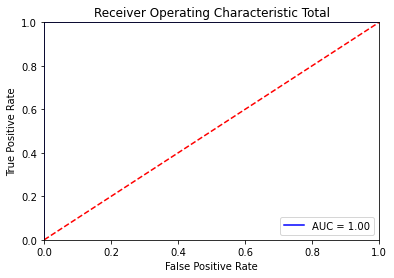

In [107]:
plt.title('Receiver Operating Characteristic Total')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--');plt.xlim([0, 1]);plt.ylim([0, 1])
plt.ylabel('True Positive Rate');plt.xlabel('False Positive Rate')
plt.show()

# Random Forest Results

### Accuracy: 100%
### Precision: 100%
### Recall: 100%